In [330]:
import numpy as np
import scipy.spatial.distance
import scipy.interpolate
import scipy.optimize
from PIL import Image
from pathlib import Path
import pandas
from natsort import natsorted

np.set_printoptions(suppress=True)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.mlab as mlab
import matplotlib.image as mpimg

In [96]:
def load(fn):
    return np.array(Image.open(fn))


def load_tif_data(directory, xstart=0, xend=None, ystart=0, yend=None, verbose=False):
    p = Path(directory)
    fns = natsorted(p.glob("*.tif"))
    nframes = len(fns)
    if verbose:
        print(f"Loading {nframes} tif images...")

    # Load one tif to get the size
    tif = load(fns[0])
    xsize, ysize = tif.shape

    if xend is None:
        xend = xsize
    if yend is None:
        yend = ysize

    xsize = xend - xstart
    ysize = yend - ystart

    data = np.zeros((xsize, ysize, nframes), dtype=np.float)

    for i, fn in enumerate(fns):
        data[:,:,i] = load(fn)[xstart:xend, ystart:yend]
        if verbose and i % 1000 == 0:
            print(i)
    if verbose:
        print("Finished loading data!")

    return data

In [20]:
def load_mask(filename):
    mask = np.loadtxt(filename).astype(np.bool)
    mask = np.rot90(np.fliplr(mask))
    return mask

(240, 320)


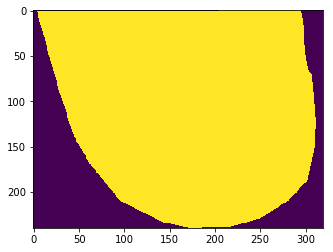

In [21]:
mask = load_mask("/Users/jjmaldonis/Downloads/full_ROI.itx")
print(mask.shape)
plt.imshow(mask)
plt.show()

In [98]:
data = load_tif_data("/Users/jjmaldonis/Downloads/cropped/", verbose=True)
I, J, NFRAMES = data.shape
data.shape

Loading 4000 tif images...
0
1000
2000
3000
Finished loading data!


(240, 320, 4000)

In [ ]:
# Set outlying region of data to np.nan
data[~mask, :] = np.nan

/Users/jjmaldonis/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less_equal
  


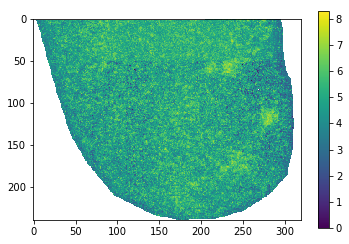

In [400]:
x = data[:, :, 0].copy()
x[x <= 0] = np.nan
x = np.log(x)
plt.imshow(x)
plt.colorbar()
plt.show()

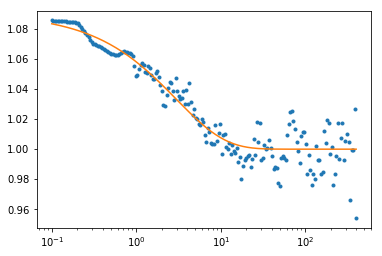

(0.090116926187626553, 7.5043169915203114, 0.75004101606847784)


In [391]:
def g2(y, lag):
    end = len(y) - lag
    ylag = y[lag:]
    y0 = y[:end]
    assert len(ylag) == len(y0)
    #return np.mean(ylag * y0) / np.mean(y)**2
    return np.mean(ylag * y0) / (np.mean(ylag) * np.mean(y0))


def calculate_rescaled_g2(data, dt, i, j):
    y = data[i, j, :]
    
    I, J, NFRAMES = data.shape
    X = np.arange(0, NFRAMES, 1)
    Xts = X * dt
    
    p = np.arange(0, 200)
    t_resampled = np.power(10,
                np.log10(dt) + (p/(len(p)-1)*(np.log10(dt*NFRAMES-1)-np.log10(dt)))
                )

    # Figure out what values of `t` we need to calculate for g2(t)
    lag = set()
    for x in t_resampled:
        lag.add(int(np.floor(x/dt)))
        lag.add(int(np.ceil(x/dt)))
    lag = np.array(sorted(lag))
    
    g2s = [g2(y, lag=l) for l in lag]
    g2s = np.array(g2s)
    
    fg2 = scipy.interpolate.interp1d(lag*dt, g2s,
                                     kind='linear')
                                     #fill_value=1.0, bounds_error=False)
    
    g2_resampled = fg2(t_resampled)
    return t_resampled, g2_resampled


def stretched_exponential(t, A, tau, beta):
    return 1 + A * np.exp(-2. * np.power(t/tau, beta))

def fit_g2(x, y):
    #A, tau, beta = 0.5, 10, 1
    popt, pcov = scipy.optimize.curve_fit(stretched_exponential,
                                          x, y)
                                          #, p0=[A, tau, beta])
    return popt


def get_results(data, dt, i, j, plot=False):
    t_resampled, g2_resampled = calculate_rescaled_g2(data, dt, i, j)

    if plot:
        plt.semilogx(t_resampled, g2_resampled, '.')

    A, tau, beta = fit_g2(t_resampled, g2_resampled)
    if plot:
        fit = stretched_exponential(t_resampled, A, tau, beta)
        plt.plot(t_resampled, fit, '-')
        plt.show()
    return A, tau, beta


plot = False
i, j = 230, 170
dt = 0.1
r = get_results(data, dt, i, j, plot=True)
print(r)

In [ ]:
def calculate_g2(args):
    data, lag, NFRAMES = args
    start = time.time()
    end = NFRAMES - lag
    datalag = data[:, lag:]
    data0 = data[:, :end]
    assert datalag.shape == data0.shape
    g2s_lag = np.mean(datalag * data0, axis=1) / (np.mean(datalag, axis=1) * np.mean(data0, axis=1))
    end = time.time()
    print(f"Duration: {end - start}")
    return g2s_lag

def stretched_exponential(t, A, tau, beta):
    return 1 + A * np.exp(-2. * np.power(t/tau, beta))

def fit(args):
    t_resampled, LAG, dt, g2 = args
    
    A = g2[0] - 1.
    tau = 100.*dt
    beta = 1.
    p0 = [A, tau, beta]
    fg2 = scipy.interpolate.interp1d(LAG*dt, g2, kind='linear')
    g2_resampled = fg2(t_resampled)
    try:
        popt, pcov = scipy.optimize.curve_fit(
            stretched_exponential, t_resampled, g2_resampled, p0=p0
        )
    except RuntimeError:
        popt = np.zeros((3,))
        popt.fill(np.nan)
    return popt


def calculate_all_rescaled_g2s(data, mask, dt):    
    I, J, NFRAMES = data.shape
    X = np.arange(0, NFRAMES, 1)
    Xts = X * dt
    
    p = np.arange(0, 200)
    t_resampled = np.power(10,
                np.log10(dt) + (p/(len(p)-1)*(np.log10(dt*NFRAMES-1)-np.log10(dt)))
                )

    # Figure out what values of `t` we need to calculate for g2(t)
    LAG = set()
    for t in t_resampled:
        LAG.add(int(np.floor(t/dt)))
        LAG.add(int(np.ceil(t/dt)))
    LAG = np.array(sorted(LAG))
    
    # Reshape the data
    data = data.reshape((I*J, NFRAMES))
    mask = mask.reshape((I*J,))
    assert mask.shape[0] == data.shape[0]
    data = data[np.where(mask), :]
    data = data.reshape(*data.shape[1:])
    print(f"Data shape: {data.shape}")
    
    pool = Pool(20)
    g2_resampled = pool.map(calculate_g2, ((data, lag, NFRAMES) for lag in LAG))
    g2_resampled = np.array(g2_resampled).T
    #g2_resampled = np.zeros((data.shape[0], len(LAG)))
    #for l, lag in enumerate(LAG):
    #    g2_resampled[:, l] = calculate_g2(data, lag, NFRAMES)

    fit_results = pool.map(fit, ((t_resampled, LAG, dt, y) for y in g2_resampled))
    #fit_results = np.zeros((data.shape[0], 3))
    #for i, y in enumerate(g2_resampled):
    #    fit_results[i, :] = fit(t_resampled, LAG, dt, y)
    return fit_results
    
    w_reshaped_mask = np.where(mask)
    mask = mask.reshape((I, J))
    w_mask = np.where(mask)
    fixed_shape_fit_results = np.zeros((I, J, 3))
    fixed_shape_fit_results.fill(np.nan)
    for k in range(len(w_reshaped_mask[0])):
        i, j = w_mask[0][k], w_mask[1][k]
        r = w_reshaped_mask[0][k]
        fixed_shape_fit_results[i, j] = fit_results[r]
    
    return fixed_shape_fit_results